<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# German News Articles

by Joel Akeret and Fabian Märki

## Summary
This is a short intro on how to access the *Ten Thousand German News Articles Dataset* for the *default project* (we still encourage you to work with your own dataset).

## Links
- [Ten Thousand German News Articles Dataset](https://tblock.github.io/10kGNAD/)

<a href="https://colab.research.google.com/github/markif/2021_HS_DAS_NLP_Notebooks/blob/master/XX_German_News_Article.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install 'fhnw-nlp-utils>=0.1.3' pyarrow fastparquet

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


We propose to use the stratified train/test split proposed by the maintainer of the dataset.

In [2]:
file = "data/german_news_articles_original_train.parq"
download("https://drive.google.com/uc?id=1EuluVm0PX-akbh_EN-jZM2QbxXZ1uDeq", file)
data_train = load_dataframe(file)

file = "data/german_news_articles_original_test.parq"
download("https://drive.google.com/uc?id=1XI2yUaDaAy0PlD-ETiK8VMV_W1vOQ97n", file)
data_test = load_dataframe(file)

Get a first impression...

In [3]:
print(data_train.shape)
print(data_test.shape)

(9245, 2)
(1028, 2)


In [5]:
data_train["split"] = "train"
data_test["split"] = "test"

In [5]:
data_train.head(3)

,text_original,label,split
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,train
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,train
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,train


In [6]:
data_test.head(3)

,text_original,label,split
0,"Die Gewerkschaft GPA-djp lanciert den ""All-in-...",Wirtschaft,test
1,Franzosen verteidigen 2:1-Führung – Kritische ...,Sport,test
2,Neues Video von Designern macht im Netz die Ru...,Web,test


In [4]:
data_all = pd.concat([data_train, data_test])
data = data_train

In [16]:
data_all[data_all['label'] == 'Etat'].iloc[60, 0]

'Der Film "Crouching Tiger, Hidden Dragon: Sword of Destiny" ist ab Freitag abrufbar. Los Gatos / Wien – Schwertkämpfer und exotische Ninjas, die auf Baumwipfeln gegeneinander kämpfen: Der mehrfach preisgekrönte chinesisch-taiwanische Blockbuster Tiger and Dragon aus dem Jahr 2000 mit Chow Yun-Fat (Anna und der König) bildet die Vorgeschichte für den Martial-Arts-Film Crouching Tiger, Hidden Dragon: Sword of Destiny, der ab Freitag auf Netflix abrufbar ist. Die Regie im zweiten Teil von Tiger and Dragon übernimmt allerdings nicht mehr Ang Lee (Brokeback Mountain, Life of Pi), sondern Yuen Woo-ping. Er hatte schon 1978 den leichtfüßigen Jackie Chan zum Drunken Master (Sie nannten ihn Knochenbrecher) transformiert. Die Geschichte der Netflix-Produktion entführt den Zuschauer in eine mystische Zeit, in der die Gravitation anderen Regeln zu folgen scheint: balancierend auf der Spitze eines Schwertes ausharren, von Baum zu Baum gleiten, mal eben drei Meter hoch springen. Fans, die der chara

Data analysieren. Verteilung der Label

<AxesSubplot:>

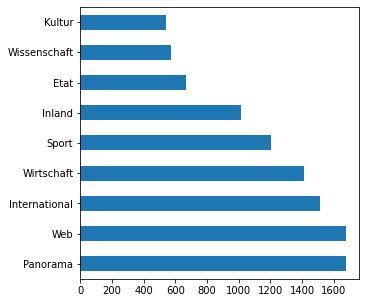

In [7]:
data_all['label'].value_counts().plot.barh(figsize=(5,5))

Es scheint keine 
- Null Zellen  
- HTML Zellen zu geben
- Zelle ohne Text


In [53]:
for col in data_all.columns:
    print(col, data[col].isnull().sum())

text_original 0
label 0
split 0


In [26]:
data[data["text_original"].str.contains("/>", na=False)]

,text_original,label,split


In [55]:
data_all[~data_all["text_original"].str.contains("[A-Za-z]", na=False)]

,text_original,label,split


In [5]:
!pip install fasttext
pretrained_model = "fasttext/supervised-models/lid.176.ftz"
download(url="https://dl.fbaipublicfiles.com/"+pretrained_model, path = pretrained_model)

import fasttext
model = fasttext.load_model(pretrained_model)

def predict_lang(text):
    """Predicts the language of a sentence

    Parameters
    ----------
    text : str
        The text to predict the language
        
    Returns
    -------
    str
        The predicted language (e.g. en, de, ...)
    """
        
    lang = model.predict(text)[0]
    return str(lang)[11:13]

def predict_lang_df(df, field_read="text", field_write="lang"):
    """Predicts the language of a column of text by calling predict_lang (primarily meant for parallel processing)

    Parameters
    ----------
    df : dataframe
        The dataframe
    field_read : str
        The column name to read from (default is text)
    field_write : str
        The column name to write to (default is lang)
        
    Returns
    -------
    dataframe
        The dataframe with the predicted language
    """
    
    # do not grow the dataframe directly - see https://stackoverflow.com/a/56746204
    series = df[field_read].map(
        lambda x: predict_lang(x)
    )
    
    return series.to_frame(field_write)

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [56]:
predict_lang_df(data_all, 'text_original').value_counts()

lang
de      10273
dtype: int64

In [8]:
%%time
from fhnw.nlp.utils.text import clean_text_df

data_all = parallelize_dataframe(data_all, clean_text_df, field_read="text_original", field_write="text_clean", n_cores=10)

CPU times: user 580 ms, sys: 924 ms, total: 1.5 s
Wall time: 827 ms


In [ ]:
data_all.head(10)

In [87]:
save_dataframe(data_all, "data/german_news_articles_original_train_and_test.parq")

In [10]:
!pip install 'spacy>=3.0.5'
!pip install nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import spacy
!python3 -m spacy download de_core_news_lg

nlp = spacy.load("de_core_news_lg")

import nltk
nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer("german")
stopwords = set(stopwords.words("german"))
#stopwords = set(nlp.Defaults.stop_words)
empty_stopwords = set()

     |████████████████████████████████| 5.9 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 23.0 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 30.5 MB/s eta 0:00:01
     |████████████████████████████████| 10.2 MB 18.0 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 5.0 MB/s  eta 0:00:01
     |████████████████████████████████| 625 kB 43.3 MB/s eta 0:00:01
     |████████████████████████████████| 456 kB 31.2 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 9.9 MB/s  eta 0:00:01
     |████████████████████████████████| 103 kB 12.5 MB/s eta 0:00:01
  Created wheel for contextvars: filename=contextvars-2.4-py3-none-any.whl size=7680 sha256=1959ecfa376adbbad76b8a35d3a8473df4830a92f22ba76c9988b27713a769c4
  Stored in directory: /root/.cache/pip/wheels/41/11/53/911724983aa48deb94792432e14e518447212dd6c5477d49d3
Successfully built contextvars
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' 

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
%%time
from fhnw.nlp.utils.normalize import normalize_df

data_all = parallelize_dataframe(data_all, normalize_df, stopwords=stopwords, field_read="text_clean", field_write="token_clean", 
            stemmer=None, lemmanizer=None, lemma_with_ner=False, n_cores=10)
data_all

CPU times: user 791 ms, sys: 185 ms, total: 976 ms
Wall time: 3.06 s


,text_original,label,split,text_clean,token_clean
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,train,Jähriger fällt wohl bis Saisonende aus Wien R...,"[jähriger, fällt, wohl, saisonende, wien, rapi..."
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,train,Erfundene Bilder zu Filmen die als verloren ge...,"[erfundene, bilder, filmen, verloren, gelten, ..."
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,train,Der frischgekürte CEO Sundar Pichai setzt auf ...,"[frischgekürte, ceo, sundar, pichai, setzt, um..."
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",Wirtschaft,train,Putin Einigung dass wir Menge auf Niveau von J...,"[putin, einigung, menge, niveau, jänner, halte..."
4,Estland sieht den künftigen österreichischen P...,Inland,train,Estland sieht den künftigen österreichischen P...,"[estland, sieht, künftigen, österreichischen, ..."
...,...,...,...,...,...
1023,"Programm ""Ebay Plus"" soll Ende September start...",Web,test,Programm Ebay Plus soll Ende September starten...,"[programm, ebay, plus, ende, september, starte..."
1024,"Fehlerhafte Bilanz 2013, Partei will berufen –...",Inland,test,Fehlerhafte Bilanz Partei will berufen Keine S...,"[fehlerhafte, bilanz, partei, berufen, strafe,..."
1025,Als erster Olympia-Champion auch Hawaii-Sieger...,Sport,test,Als erster Olympia Champion auch Hawaii Sieger...,"[erster, olympia, champion, hawaii, sieger, ni..."
1026,Der Außenseiter aus Denver gewinnt die 50. Sup...,Sport,test,Der Außenseiter aus Denver gewinnt die Super B...,"[außenseiter, denver, gewinnt, super, bowl, ca..."


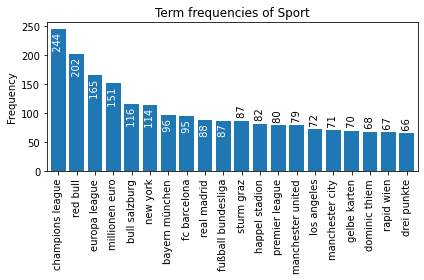

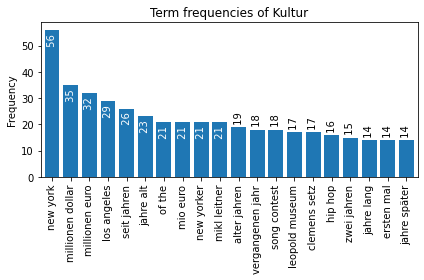

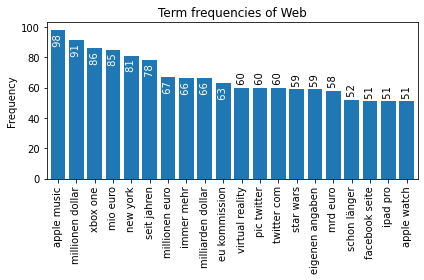

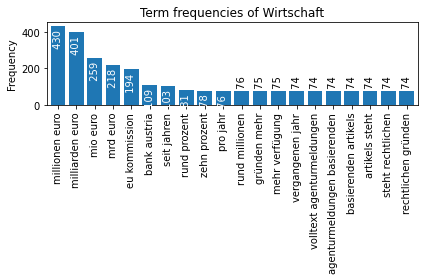

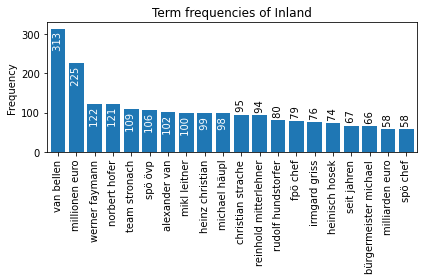

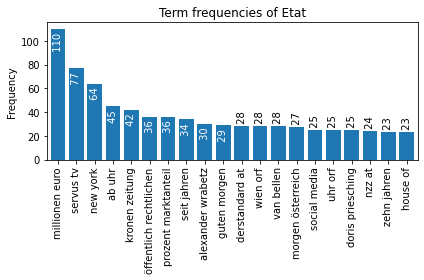

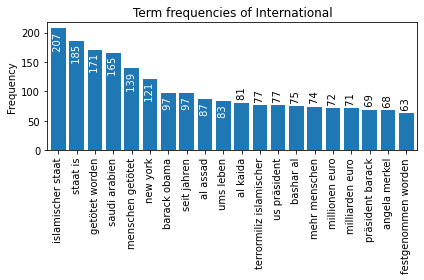

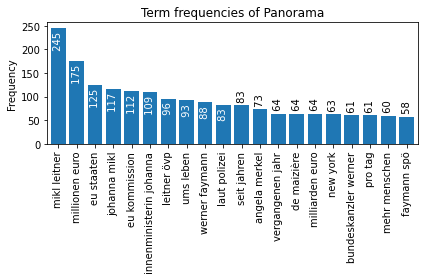

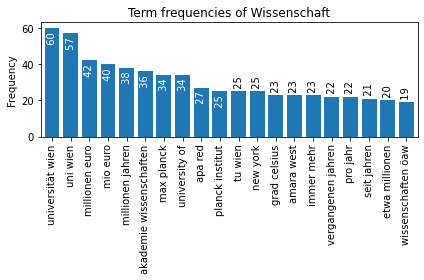

CPU times: user 3.52 s, sys: 1.89 s, total: 5.42 s
Wall time: 3.28 s


In [12]:
%%time
from fhnw.nlp.utils.text import create_ngram_counts
from fhnw.nlp.utils.ploting import plot_ngram_counts

for row, label in enumerate(data_all["label"].unique()):
    ngrams_1 = create_ngram_counts(data_all.loc[(data["label"] == label)], 1, field_read='token_clean')
    ngrams_2 = create_ngram_counts(data_all.loc[(data["label"] == label)], 2, field_read='token_clean')
    
    # plot_ngram_counts(ngrams_1, 20, "Term frequencies of "+label)
    plot_ngram_counts(ngrams_2, 20, "Term frequencies of "+label)


In [9]:
stopwords.add("millionen")
stopwords.add("milliarden")
stopwords.add("euro")
stopwords.add("dollar")
stopwords.add("mio")
stopwords.add("mrd")

In [13]:
data_all = data_all.drop(columns=['token_clean'], errors='ignore')
data_all = parallelize_dataframe(data_all, normalize_df, stopwords=stopwords, field_read="text_clean", field_write="token_clean", 
            stemmer=None, lemmanizer=None, lemma_with_ner=False)
data_all

,text_original,label,split,text_clean,token_clean
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,train,Jähriger fällt wohl bis Saisonende aus Wien R...,"[jähriger, fällt, wohl, saisonende, wien, rapi..."
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,train,Erfundene Bilder zu Filmen die als verloren ge...,"[erfundene, bilder, filmen, verloren, gelten, ..."
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,train,Der frischgekürte CEO Sundar Pichai setzt auf ...,"[frischgekürte, ceo, sundar, pichai, setzt, um..."
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",Wirtschaft,train,Putin Einigung dass wir Menge auf Niveau von J...,"[putin, einigung, menge, niveau, jänner, halte..."
4,Estland sieht den künftigen österreichischen P...,Inland,train,Estland sieht den künftigen österreichischen P...,"[estland, sieht, künftigen, österreichischen, ..."
...,...,...,...,...,...
1023,"Programm ""Ebay Plus"" soll Ende September start...",Web,test,Programm Ebay Plus soll Ende September starten...,"[programm, ebay, plus, ende, september, starte..."
1024,"Fehlerhafte Bilanz 2013, Partei will berufen –...",Inland,test,Fehlerhafte Bilanz Partei will berufen Keine S...,"[fehlerhafte, bilanz, partei, berufen, strafe,..."
1025,Als erster Olympia-Champion auch Hawaii-Sieger...,Sport,test,Als erster Olympia Champion auch Hawaii Sieger...,"[erster, olympia, champion, hawaii, sieger, ni..."
1026,Der Außenseiter aus Denver gewinnt die 50. Sup...,Sport,test,Der Außenseiter aus Denver gewinnt die Super B...,"[außenseiter, denver, gewinnt, super, bowl, ca..."


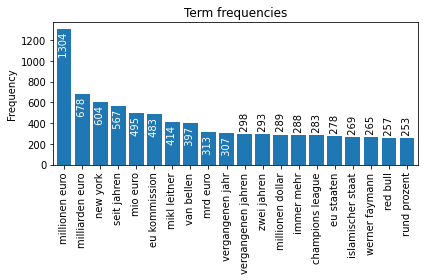

CPU times: user 1.52 s, sys: 143 ms, total: 1.66 s
Wall time: 1.52 s


In [13]:
%%time
from fhnw.nlp.utils.text import create_ngram_counts
from fhnw.nlp.utils.ploting import plot_ngram_counts

ngrams = create_ngram_counts(data_all,  field_read='token_clean')
plot_ngram_counts(ngrams, 20, "Term frequencies")
    


In [17]:
%%time
from fhnw.nlp.utils.normalize import normalize_df 

data_all = data_all.drop(columns=["token_lemma", 'token_stem', 'token_clean_stopwords'], errors='ignore')
data_all = parallelize_dataframe(data_all, normalize_df, field_read="text_clean", field_write="token_lemma", stopwords=stopwords, stemmer=None, lemmanizer=nlp, lemma_with_ner=False, n_cores=6)
print('Lemma done')
data_all = parallelize_dataframe(data_all, normalize_df, field_read="text_clean", field_write="token_stem", stopwords=stopwords, stemmer=stemmer, lemmanizer=None, lemma_with_ner=False, n_cores=6)
print('Stem done')
data_all = parallelize_dataframe(data_all, normalize_df, field_read="text_clean", field_write="token_clean_stopwords", stopwords=stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False, n_cores=6)

Lemma done
Stem done
CPU times: user 32.6 s, sys: 6.35 s, total: 38.9 s
Wall time: 1min 14s


In [16]:
%%time
from fhnw.nlp.utils.normalize import normalize_df 

data_all = data_all.drop(columns=["token_lemma", 'token_stem', 'token_clean_stopwords'], errors='ignore')
# whatever = normalize_df(data_all, field_read="text_clean", field_write="token_lemma", stopwords=stopwords, stemmer=None, lemmanizer=nlp, lemma_with_ner=False)
data_all = parallelize_dataframe(data_all, normalize_df, field_read="text_clean", field_write="token_lemma", stopwords=stopwords, stemmer=None, lemmanizer=nlp, lemma_with_ner=False, n_cores=4)


CPU times: user 20.6 s, sys: 4.02 s, total: 24.6 s
Wall time: 1min 2s


In [18]:
%%time
save_dataframe(data_all, "data/german_news_articles_original_train_and_test_tokenized.parq")
data_all

CPU times: user 8.66 s, sys: 203 ms, total: 8.87 s
Wall time: 8.96 s


,text_original,label,split,text_clean,token_clean,token_lemma,token_stem,token_clean_stopwords
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,train,Jähriger fällt wohl bis Saisonende aus Wien R...,"[jähriger, fällt, wohl, saisonende, wien, rapi...","[jähriger, fällen, wohl, saisonende, wien, rap...","[jahrig, fallt, wohl, saison, wien, rapid, woh...","[jähriger, fällt, wohl, saisonende, wien, rapi..."
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,train,Erfundene Bilder zu Filmen die als verloren ge...,"[erfundene, bilder, filmen, verloren, gelten, ...","[erfundene, bild, film, verlieren, gelten, the...","[erfund, bild, film, verlor, gelt, the, forbid...","[erfundene, bilder, filmen, verloren, gelten, ..."
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,train,Der frischgekürte CEO Sundar Pichai setzt auf ...,"[frischgekürte, ceo, sundar, pichai, setzt, um...","[frischgekürte, ceo, sundar, pichai, setzen, u...","[frischgekurt, ceo, sundar, pichai, setzt, umg...","[frischgekürte, ceo, sundar, pichai, setzt, um..."
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",Wirtschaft,train,Putin Einigung dass wir Menge auf Niveau von J...,"[putin, einigung, menge, niveau, jänner, halte...","[putin, einigung, menge, niveau, jänner, halte...","[putin, einig, meng, niveau, jann, halt, moska...","[putin, einigung, menge, niveau, jänner, halte..."
4,Estland sieht den künftigen österreichischen P...,Inland,train,Estland sieht den künftigen österreichischen P...,"[estland, sieht, künftigen, österreichischen, ...","[estland, sehen, künftig, österreichisch, präs...","[estland, sieht, kunftig, osterreich, prasiden...","[estland, sieht, künftigen, österreichischen, ..."
...,...,...,...,...,...,...,...,...
1023,"Programm ""Ebay Plus"" soll Ende September start...",Web,test,Programm Ebay Plus soll Ende September starten...,"[programm, ebay, plus, ende, september, starte...","[programm, ebay, plus, ende, september, starte...","[programm, ebay, plus, end, septemb, start, de...","[programm, ebay, plus, ende, september, starte..."
1024,"Fehlerhafte Bilanz 2013, Partei will berufen –...",Inland,test,Fehlerhafte Bilanz Partei will berufen Keine S...,"[fehlerhafte, bilanz, partei, berufen, strafe,...","[fehlerhafte, bilanz, partei, berufen, strafe,...","[fehlerhaft, bilanz, partei, beruf, straf, weg...","[fehlerhafte, bilanz, partei, berufen, strafe,..."
1025,Als erster Olympia-Champion auch Hawaii-Sieger...,Sport,test,Als erster Olympia Champion auch Hawaii Sieger...,"[erster, olympia, champion, hawaii, sieger, ni...","[erst, olympia, champion, hawaii, sieger, nied...","[erst, olympia, champion, hawaii, sieg, nieder...","[erster, olympia, champion, hawaii, sieger, ni..."
1026,Der Außenseiter aus Denver gewinnt die 50. Sup...,Sport,test,Der Außenseiter aus Denver gewinnt die Super B...,"[außenseiter, denver, gewinnt, super, bowl, ca...","[außenseiter, denver, gewinnen, super, bowl, c...","[aussenseit, denv, gewinnt, sup, bowl, carolin...","[außenseiter, denver, gewinnt, super, bowl, ca..."
